# Data Mining for Security Applications: final project

This final hands on project will count for 50% of your final grade (exam is the other 50%)

## Organization
* you can start the project as of now
* the project has to be handed in no later than March 1st - NO EXTENSIONS!

### Project Submission 
* hand in a single jupyter notebook for your project (via moodle)
* set all paths as relative paths such that the data is in the same folder as the notebook
* your notebook should run without errors (uncomment parts that do not work)
* Use markdown cells and comments in the code to document and motivate you solution
* show and analyze intermediate results
* evaluate and discuss your solution

### Grading Criteria
* 4.0 : notebook that works and gives some solution to the problem
* 3.0 : + good documentation, evaluation and discussion
* 2.0 : + complete processing pipeline, good results
* 1.0 : + very detailed documentation and analysis, hyper-parameter optimization, tried and compared more than one method 



# Task: Breaking image captchas  

We are working on this Kaggle Challenge: https://www.kaggle.com/fournierp/captcha-version-2-images  

HINT: have a good look at the problem description and the notebooks of other users to get started 

* Train and test images are in the according folders
* The true labels are encoded in the file names 

## Tasks to follow:
* write code to read the images [use the imageio lib](https://imageio.readthedocs.io/en/stable/userapi.html) and convert then into NUMPY feature vectors
and labels
    * HINT: use [the os lib](https://docs.python.org/2/library/os.html#os.listdir) to get files in a directory
* the hardest part is to solve the segmentation problem: splitting the image into single characters
    * try Clustering over pixel positions
    * or a density projection along the y-axis
* crate a training data set of labeled character segments
    * evaluate this step
* train a CNN or MLP network to classify character segments
    * evaluate this step
* build a full pipeline to transform capcha image inputs into strings
* Evaluate and discuss your results

In [1]:
#Pip installs for all packages if needed
#!pip install os
#!pip install imageio
#!pip install opencv-python
#!pip install matplotlib
#!pip install tensorflow
#!pip install keras


#Importing all needed packages
import os
import imageio
import numpy as np
from cv2 import cv2
import string
import matplotlib.pyplot as plt
%matplotlib inline
import keras

# Results are writen to the current directory are saved as output.
from keras.layers import Layer
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks

Using TensorFlow backend.
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/t

First visualization of data set and how with importing in with imageio the images apppears in plots. This helps distingish if the image is brought in as indiviual letter/numbers or the full image is stored. 

(50, 200)


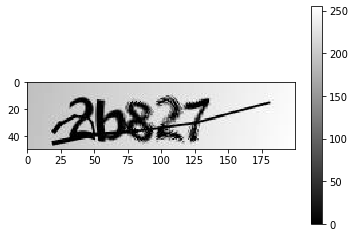

In [2]:
#Example of how imageio reads the data in visual form. the Captcha is in a clear dark purple. 
image = imageio.imread('../Project/train/2b827.png', as_gray=True)
print(image.shape)

plt.figure()
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

After we know how the image comes in we can set up a function to import and store all the images for testing or training sets. According to the Kaggle information all images are in 50 by 200 PNGS. Also found online are the symbols avaible to Captcha, which we can utilized for ensure the y match up with the limited options for Captcha.

In [3]:
#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

#preprocessing the data into Numpy array's
def preprocess_data(type):
    n_samples = len(os.listdir(f'../Project/{type}'))
    X = np.zeros((n_samples, 50, 200, 1)) # the size of image is known to be 200 x 50 PNGs #970*50*200 shape
    y = np.zeros((5, n_samples, num_symbols)) #5*970*36 shape

    for i,pic in enumerate(os.listdir(f'../Project/{type}')):
        # Read image as grayscale
        img = cv2.imread(os.path.join(f'../Project/{type}',pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

After setting up a clear pipeline stored in classes and functions above we can start utilizing them to train and test the models. Below we utlize the relative paths of train and test folders to set up the X,y datasets. Stored in preprocess_data() is our function for utilizing imageio lib for storing the data in vectors. Note: we utilized `as_gray=True` to indicate the images are in grey scale this reduces our shape from a (5,200,4) to (5,200) which aligns with the size of images perfectly. 

In [4]:
#Create Train and Test sets
X_train, y_train = preprocess_data('train')
X_test, y_test = preprocess_data('test')

print("Shapes of X: train", X_train.shape, "test", X_test.shape)
print("Shapes of y: train", y_train.shape, "test", y_test.shape)

Shapes of X: train (970, 50, 200, 1) test (100, 50, 200, 1)
Shapes of y: train (5, 970, 36) test (5, 100, 36)


As can be seen below the each of the images are stored in arrays but it is a bit of guess work on seperating out the individual character arrays within the individual image arrays stored. We will take care of this within the model itself utilizing flatteing of image and branches. 


## Model Creation

Now that the data stored in the X,y for train and test we can create a CNN model. We are utilizing a CNN model because were designed for image mapping. https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/. In creating the model we need to breadown the image from a whole view to try to get section of each letter/number for the model to match. Since we know there are only 5 characters in the captcha images we  can use this for setting up 5 branches for the CNN. The activation function of relu was selected  in betwenn layers as this is a pretty standard starting point and is more computationally effiecent. Since the ultimate goal would be to accurately predict to break the captcha the evaluation metric being used is overall accuracy. 

In [5]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [6]:
#Setup the Model, History Logs, 
model = create_model()


In [7]:
#Model fitting
hist = model.fit(X_train, [y_train[0],y_train[1], y_train[2], y_train[3], y_train[4]],
                 validation_data=(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]]),
                 batch_size=32,
                 epochs=30, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 970 samples, validate on 100 samples
Epoch 1/30
970/970 [==============================] - 5s 5ms/step - loss: 17.0344 - dense_2_loss: 3.4041 - dense_4_loss: 3.3865 - dense_6_loss: 3.3861 - dense_8_loss: 3.4201 - dense_10_loss: 3.4181 - dense_2_accuracy: 0.0495 - dense_4_accuracy: 0.0773 - dense_6_accuracy: 0.0577 - dense_8_accuracy: 0.0546 - dense_10_accuracy: 0.0588 - val_loss: 17.3869 - val_dense_2_loss: 3.4976 - val_dense_4_loss: 3.4880 - val_dense_6_loss: 3.4714 - val_dense_8_loss: 3.4691 - val_dense_10_loss: 3.4665 - val_dense_2_accuracy: 0.0400 - val_dense_4_accuracy: 0.0500 - val_dense_6_accuracy: 0.0200 - val_dense_8_accuracy: 0.0500 - val_dense_10_accuracy: 0.0900
Epoch 2/30
970/970 [==============================] - 2s 2ms/step - loss: 15.7954 - dense_2_loss: 3.1536 - dense_4_loss: 3.1297 - dense_6_loss: 3.1314 - dense_8_loss: 3.1863 - dense_10_loss: 3.1805 - dense_2_accur

In [8]:
#Model Evaluation
score_test = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],  verbose=1)
                            
print("Accuracy of Testing: ",score_test)

100/100 [==============================] - 0s 689us/step
Accuracy of Testing:  [2.6400052523612976, 0.06376636028289795, 0.6007993221282959, 0.5490698218345642, 0.45493197441101074, 0.5084739923477173, 0.9800000190734863, 0.8999999761581421, 0.8700000047683716, 0.8899999856948853, 0.8700000047683716]


## Intrepretation of results

From the results of the test we can see that the model trained pretty well the 5 numbers give us the accuracy per letter. This averages for an overall 89%. This is fairly accurate.  We can see that middle character has the overall lowest accuracy if we keep in mind there is a line slated through all the images this would probably be the contributed factor as it would bemore like to confus the image for another character. 

## Predicting Results

A model is useless unless you can put it into production. So for this we will need to create a function that we can call and predict  the results from. This can also act as another form of validation

In [19]:
def predict(fileloc):
    to_predict = cv2.imread(fileloc, cv2.IMREAD_GRAYSCALE)
    actual = ''
    if to_predict is not None:
        to_predict = to_predict/ 255.0

    else: 
        print("File not found")
        
    res = np.array(model.predict(to_predict[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    
    l_ind = []
    for a in ans: 
        l_ind.append(np.argmax(a))

        
    capt = ''
    for l in l_ind:
        capt += symbols[l]
        
    return capt
        

In [20]:
print(predict('../Project/train/22d5n.png'))
print(predict('../Project/train/25w53.png'))
print(predict('../Project/train/268g2.png'))
print(predict('../Project/train/2ycn8.png'))

22d5n
25w53
268g2
2ycn8
